## IB correction for sea level heights from tide gauges

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
# Adjust the datapath to your needs.
datapath = '/data/depot/0_data_copies/'

#### Dataset downloaded in this notebook:
- ERA5 global monthly mean sea level pressure for the period 01/1992 - 12/2021, if it is not downloaded it is expected to be in a subfolder '8_ERA5' with filename 'dataset2.nc'

#### Dataset required to run this notebook:
- Land-ocean mask ('land_mask_0p25_oceanFull_invGrd.nc') expected to be in a subfolder '9_masks'

In [3]:
g = 9.80665 # mean gravitational acceleration [m/s^2]
d = 1027 # standard value for ocean surface water density [kg/m^3]

#### Download ERA5 global monthly mean sea level pressure for the period 01/1992 - 12/2021

#### Compute and save monthly IB correction

In [4]:
ds = xr.open_dataset(datapath + '/8_ERA5/dataset2.nc', engine='netcdf4')

ocean mask:

In [5]:
mask = xr.open_dataset(datapath + '/9_masks/land_mask_0p25_oceanFull_invGrd.nc', engine='netcdf4')
mask = mask.squeeze('time').reset_coords('time', drop=True)
mask = mask.z > 0.5
mask = mask[:,:1440]
mask = np.flipud(mask)
mask_temp1 = mask[:,:720]
mask_temp2 = mask[:,720:]
mask = np.hstack((mask_temp2, mask_temp1))
mask = np.invert(mask)
mask = np.broadcast_to(mask, ds.msl.shape)
msl_ocean = np.ma.masked_array(ds.msl, mask=mask)

latitude weighting & mean over total ocean surface:

In [9]:
weights = np.cos(ds.latitude * np.pi / 180)
weights = np.resize(weights, (len(ds.longitude),len(ds.latitude)))
weights = np.transpose(weights)
weights = np.ma.masked_array(weights, mask=mask[0])

msl_ocean_w = msl_ocean * weights
msl_ocean_w_mean = msl_ocean_w.sum(axis=(1,2)) / weights.sum()

IB correction:

In [10]:
msl_ocean_w_mean = msl_ocean_w_mean.reshape((len(msl_ocean_w_mean),1,1))
msl_ocean_w_mean = np.broadcast_to(msl_ocean_w_mean, (msl_ocean.shape))
corr = (msl_ocean - msl_ocean_w_mean) / (d * g)

Text(0.5, 1.0, 'IB correction in [m]')

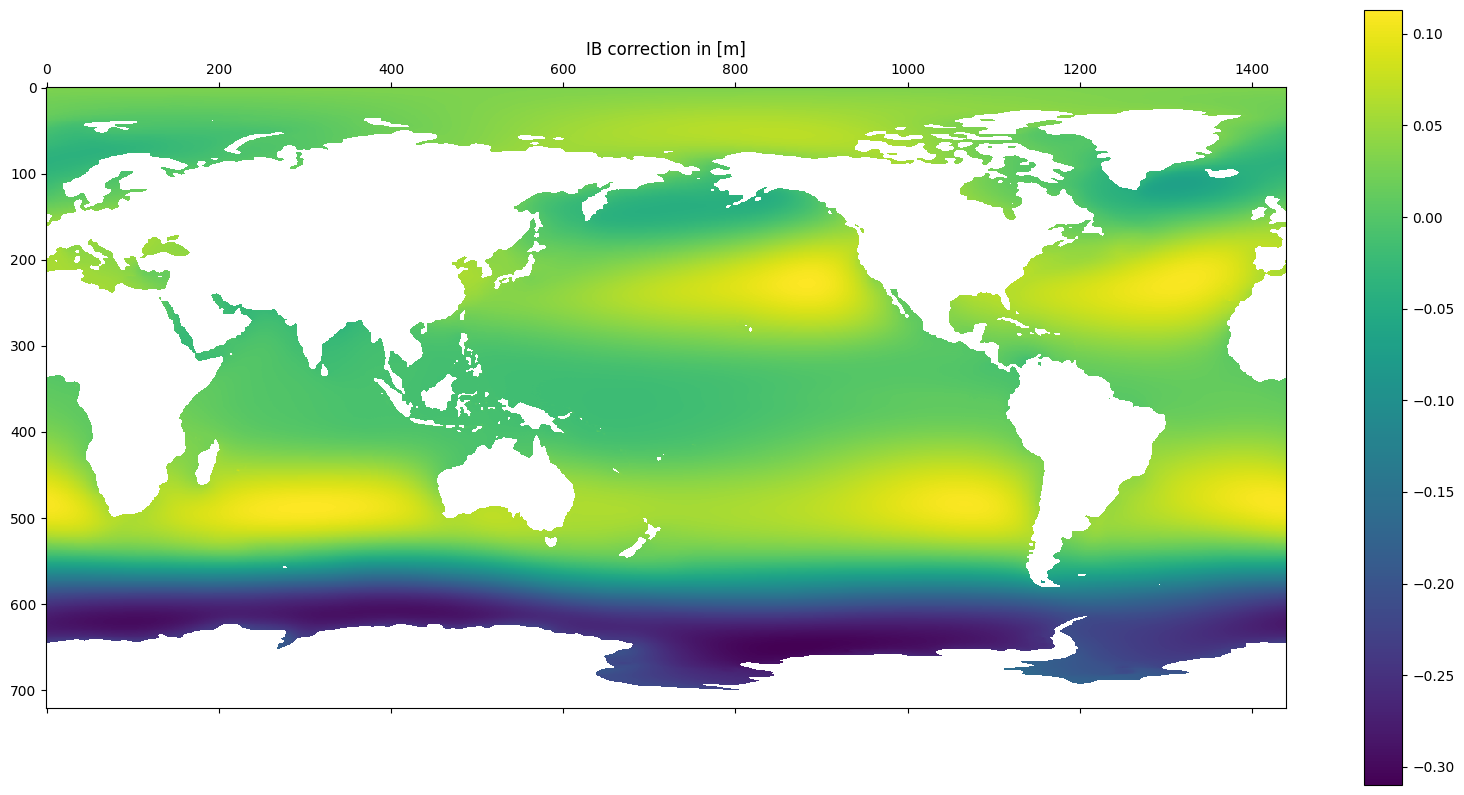

In [11]:
plt.figure(1, figsize=(20,10))
plt.matshow(corr.mean(axis=0), fignum=1)
plt.colorbar()
plt.title('IB correction in [m]')

In [12]:
data_vars = {'IB_correction':(['time', 'lat', 'lon'], corr,
            {'long_name':'Inverted barometer height correction',
            'units': 'm',
            'pressure data':'ERA5 monthly mean sea level pressure',
            'period': '01/1992 - 12/2021',
            })}

coords = {'time': (['time'], ds.time.values),
        'lat': (['lat'], ds.latitude.values),
        'lon': (['lon'], ds.longitude.values)}

attrs = {'description':'Inverted barometer correction for sea level heights from ERA5, globally.',
        'creation_date':json.dumps(datetime.now(), indent=4, sort_keys=True, default=str),
        'author':'Bene Aschenneller',
        'email':'s.aschenneller@utwente.nl'}

ds_corr = xr.Dataset(data_vars, coords, attrs)
ds_corr.to_netcdf(datapath + 'ib_correction_era5_1992-2021.nc', format='NETCDF4', encoding={'IB_correction':{'dtype':'int32', 'scale_factor': 1e-5}} )

/tmp/ipykernel_466/430611289.py:18: SerializationWarning: saving variable IB_correction with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_corr.to_netcdf(datapath + 'ib_correction_era5_1992-2021.nc', format='NETCDF4', encoding={'IB_correction':{'dtype':'int32', 'scale_factor': 1e-5}} )
